## Install Necessary Packages

In [1]:
# check tensorflow install
import tensorflow as tf
print(tf.__version__)

C:\ProgramData\Anaconda3\envs\AnomalyDetection\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [2]:
# install necessary packages
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [3]:
# set random seed
seed(10)
tf.random.set_seed(10)

## Load datasets

In [4]:
df_train = pd.read_csv('data.csv')
df_test = pd.read_csv('sample_20200212.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28898 entries, 0 to 28897
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     28898 non-null  int64  
 1   jobName                       28898 non-null  object 
 2   values_PostStage              28898 non-null  float64
 3   values_MidStage               28898 non-null  float64
 4   values_ConveyorBeltTimestamp  28898 non-null  object 
 5   sourceName                    28898 non-null  object 
 6   _timestamp                    28898 non-null  object 
 7   _version                      28898 non-null  int64  
 8   values_PreStage               28898 non-null  float64
 9   Timestamp_HR                  28898 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 2.2+ MB


In [6]:
df_train.nunique()

Timestamp                        2702
jobName                             1
values_PostStage                20158
values_MidStage                 20158
values_ConveyorBeltTimestamp        1
sourceName                          2
_timestamp                          1
_version                            1
values_PreStage                 20158
Timestamp_HR                     2702
dtype: int64

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149568 entries, 0 to 149567
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Timestamp         149568 non-null  int64  
 1   values_PostStage  149568 non-null  float64
 2   values_MidStage   149568 non-null  float64
 3   sourceName        149568 non-null  object 
 4   values_PreStage   149568 non-null  float64
 5   Timestamp_HR      149568 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 6.8+ MB


In [8]:
df_test.nunique()

Timestamp            14941
values_PostStage    102954
values_MidStage     102942
sourceName               2
values_PreStage     102948
Timestamp_HR         14941
dtype: int64

In [9]:
df_test.head()

,Timestamp,values_PostStage,values_MidStage,sourceName,values_PreStage,Timestamp_HR
0,1581498216,89.642216,66.550189,sensors1,23.833349,9:03:36
1,1581498216,89.642216,66.550189,sensors2,23.833349,9:03:36
2,1581498216,92.055269,64.740733,sensors1,26.217064,9:03:36
3,1581498216,92.055269,64.740733,sensors2,26.217064,9:03:36
4,1581498216,89.879600,63.936600,sensors1,23.439999,9:03:36


## Data Preparation

In [10]:
df_train.drop(labels=['Timestamp', 'jobName', 'values_ConveyorBeltTimestamp', '_timestamp', '_version'], axis=1, inplace=True)
df_test.drop(labels=['Timestamp'], axis=1, inplace=True)

In [11]:
df_train.head()

,values_PostStage,values_MidStage,sourceName,values_PreStage,Timestamp_HR
0,92.595291,64.930687,sensors1,27.138446,2/7/2020 9:09:09
1,90.499815,64.402893,sensors2,25.619771,2/7/2020 9:09:09
2,89.024493,65.099289,sensors1,24.361520,2/7/2020 9:09:09
3,88.263517,64.992419,sensors2,25.840487,2/7/2020 9:09:09
4,88.099106,65.409816,sensors1,26.172290,2/7/2020 9:09:09


In [12]:
df_test.head()

,values_PostStage,values_MidStage,sourceName,values_PreStage,Timestamp_HR
0,89.642216,66.550189,sensors1,23.833349,9:03:36
1,89.642216,66.550189,sensors2,23.833349,9:03:36
2,92.055269,64.740733,sensors1,26.217064,9:03:36
3,92.055269,64.740733,sensors2,26.217064,9:03:36
4,89.879600,63.936600,sensors1,23.439999,9:03:36


In [13]:
df_train_new = df_train.groupby('Timestamp_HR', as_index=False)['values_PostStage', 'values_MidStage', 'values_PreStage'].mean()
df_test_new = df_test.groupby('Timestamp_HR', as_index=False)['values_PostStage', 'values_MidStage', 'values_PreStage'].mean()

C:\ProgramData\Anaconda3\envs\AnomalyDetection\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\AnomalyDetection\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [14]:
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702 entries, 0 to 2701
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp_HR      2702 non-null   object 
 1   values_PostStage  2702 non-null   float64
 2   values_MidStage   2702 non-null   float64
 3   values_PreStage   2702 non-null   float64
dtypes: float64(3), object(1)
memory usage: 105.5+ KB


In [15]:
# set index
df_train_new.set_index('Timestamp_HR', inplace=True)

In [16]:
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2702 entries, 2/7/2020 9:09:09 to 2/7/2020 9:57:39
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   values_PostStage  2702 non-null   float64
 1   values_MidStage   2702 non-null   float64
 2   values_PreStage   2702 non-null   float64
dtypes: float64(3)
memory usage: 84.4+ KB


In [17]:
df_train_new.head()

,values_PostStage,values_MidStage,values_PreStage
Timestamp_HR,,,
2/7/2020 9:09:09,89.761779,64.819085,25.588651
2/7/2020 9:09:10,90.471943,64.696170,24.770616
2/7/2020 9:09:11,89.803776,65.278842,24.946765
2/7/2020 9:09:12,90.027319,64.789562,24.750992
2/7/2020 9:09:13,89.799183,65.006167,25.567681


In [18]:
df_train_new.to_csv('train.csv')

In [19]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14941 entries, 0 to 14940
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp_HR      14941 non-null  object 
 1   values_PostStage  14941 non-null  float64
 2   values_MidStage   14941 non-null  float64
 3   values_PreStage   14941 non-null  float64
dtypes: float64(3), object(1)
memory usage: 583.6+ KB


In [20]:
# set index
df_test_new.set_index('Timestamp_HR', inplace=True)

In [21]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14941 entries, 10:00:00 to 9:59:59
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   values_PostStage  14941 non-null  float64
 1   values_MidStage   14941 non-null  float64
 2   values_PreStage   14941 non-null  float64
dtypes: float64(3)
memory usage: 466.9+ KB


In [22]:
df_test_new.head()

,values_PostStage,values_MidStage,values_PreStage
Timestamp_HR,,,
10:00:00,90.353008,65.360978,24.839547
10:00:01,90.230590,64.393734,25.093748
10:00:02,89.918064,65.008952,25.244700
10:00:03,90.170098,65.495554,24.613488
10:00:04,90.387884,64.364900,24.819825


In [23]:
df_test_new.to_csv('test.csv')

## Define train and test dataset

In [24]:
# Define train and test dataset
df_train_new.drop(labels=['values_MidStage', 'values_PreStage'], axis=1, inplace=True)
df_test_new.drop(labels=['values_MidStage', 'values_PreStage'], axis=1, inplace=True)

In [25]:
df_train_new.head()

,values_PostStage
Timestamp_HR,
2/7/2020 9:09:09,89.761779
2/7/2020 9:09:10,90.471943
2/7/2020 9:09:11,89.803776
2/7/2020 9:09:12,90.027319
2/7/2020 9:09:13,89.799183


In [26]:
df_test_new.head()

,values_PostStage
Timestamp_HR,
10:00:00,90.353008
10:00:01,90.230590
10:00:02,89.918064
10:00:03,90.170098
10:00:04,90.387884


In [27]:
# split into train and test split
train = df_train_new
val = df_test_new

In [28]:
train.shape, val.shape

((2702, 1), (14941, 1))

## plot time domain to the frequency domain using fast Fourier transform

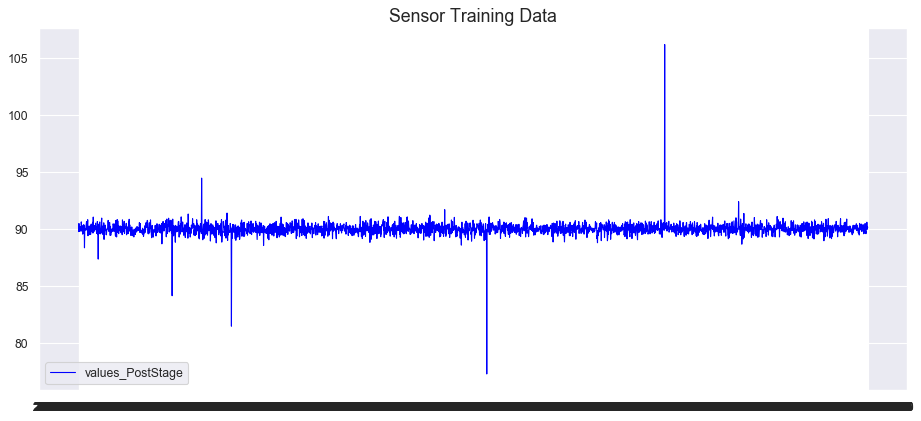

In [29]:
# Only fot values_PostStage
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['values_PostStage'], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

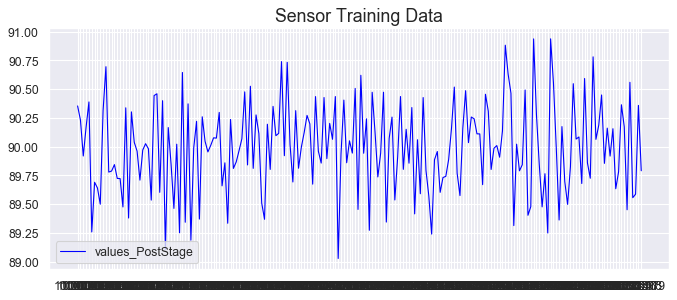

In [30]:
# Only fot values_PostStage
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)
ax.plot(val['values_PostStage'][:200], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

In [31]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
val_fft = np.fft.fft(val)

C:\ProgramData\Anaconda3\envs\AnomalyDetection\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\envs\AnomalyDetection\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  after removing the cwd from sys.path.


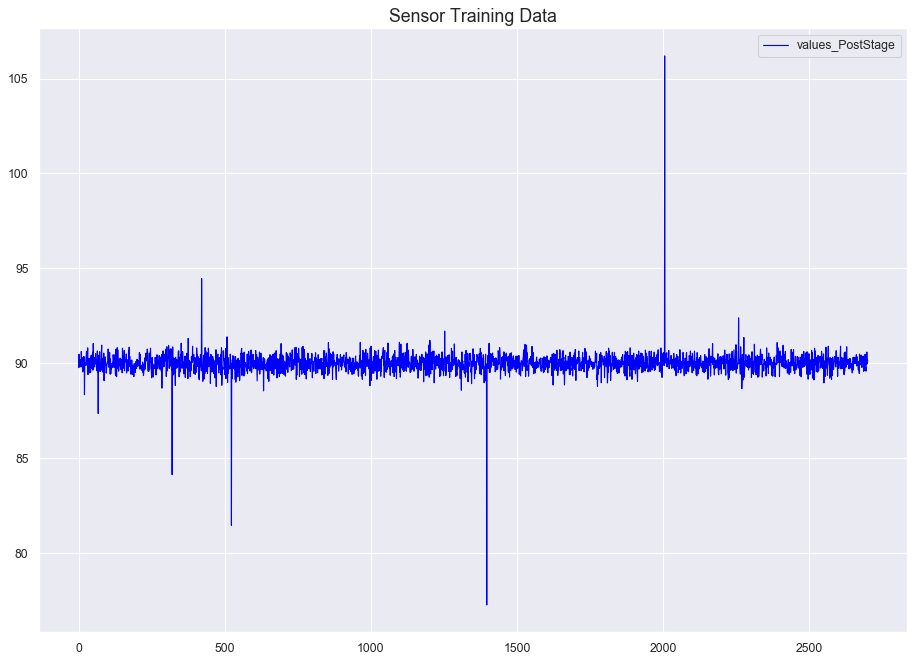

In [32]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
ax.plot(train_fft[:,0], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='top left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

C:\ProgramData\Anaconda3\envs\AnomalyDetection\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


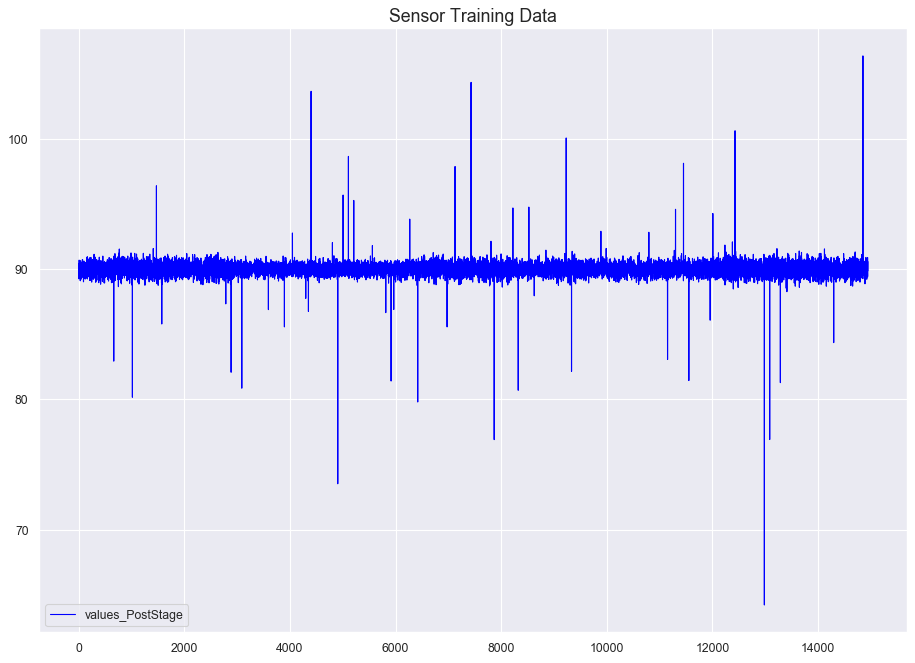

In [33]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
ax.plot(val_fft[:,0], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

## Normalize dataset

In [34]:
# first normalize it to a range between 0 and 1.
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_val = scaler.transform(val)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [35]:
X_train.shape, X_val.shape

((2702, 1), (14941, 1))

## reshape inputs for LSTM [samples, timesteps, features]

In [36]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)

Training data shape: (2702, 1, 1)
Test data shape: (14941, 1, 1)


## Define model

In [37]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [38]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              17    

## Fit the model

In [39]:
# fit the model to the data
nb_epochs = 30
batch_size = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 2566 samples, validate on 136 samples
Epoch 1/30
2566/2566 [==============================] - 14s 5ms/sample - loss: 0.4221 - val_loss: 0.4019
Epoch 2/30
2566/2566 [==============================] - 0s 89us/sample - loss: 0.3810 - val_loss: 0.3580
Epoch 3/30
2566/2566 [==============================] - 0s 78us/sample - loss: 0.3336 - val_loss: 0.3062
Epoch 4/30
2566/2566 [==============================] - 0s 67us/sample - loss: 0.2766 - val_loss: 0.2422
Epoch 5/30
2566/2566 [==============================] - 0s 68us/sample - loss: 0.2040 - val_loss: 0.1577
Epoch 6/30
2566/2566 [==============================] - 0s 67us/sample - loss: 0.1027 - val_loss: 0.0314
Epoch 7/30
2566/2566 [==============================] - 0s 71us/sample - loss: 0.0156 - val_loss: 0.0108
Epoch 8/30
2566/2566 [==============================] - 0s 74us/sample - loss: 0.0112 - val_loss: 0.0080
Epoch 9/30
2566/2566 [==============================] - 0s 80us/sample - loss: 0.0107 - val_loss: 0.0080
Epoch 10

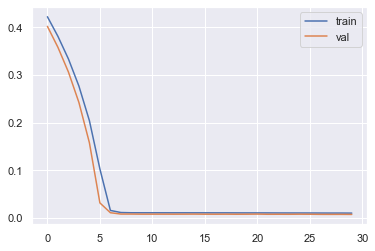

In [40]:
# plot loss
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend();

## Finding Anomalies

In [41]:
# Finding Anomalies
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

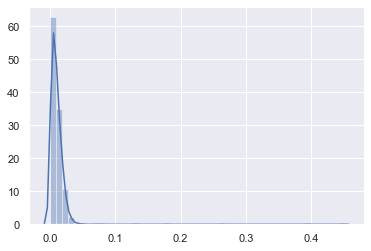

In [42]:
# look at the error:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [43]:
THRESHOLD = 0.03

In [44]:
# Let’s calculate the MAE on the test data:
X_val_pred = model.predict(X_val)

val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=1)

In [45]:
# We’ll build a DataFrame containing the loss and the anomalies (values above the threshold):
val_score_df = pd.DataFrame(index=val.index)
val_score_df['loss'] = val_mae_loss
val_score_df['threshold'] = THRESHOLD
val_score_df['anomaly'] = val_score_df.loss > val_score_df.threshold
val_score_df['values_PostStage'] = val.values_PostStage

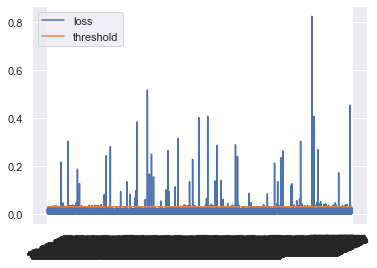

In [46]:
plt.plot(val_score_df.index, val_score_df.loss, label='loss')
plt.plot(val_score_df.index, val_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [47]:
# Looks like we’re thresholding extreme values quite well. Let’s create a DataFrame using only those:
anomalies = val_score_df[val_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,values_PostStage
Timestamp_HR,,,,
10:04:52,0.034207,0.03,True,91.141918
10:06:21,0.030880,0.03,True,88.960854
10:06:56,0.034358,0.03,True,88.845305
10:07:38,0.030047,0.03,True,91.001377
10:08:03,0.031382,0.03,True,88.944178


## Plot Anomalies on test data

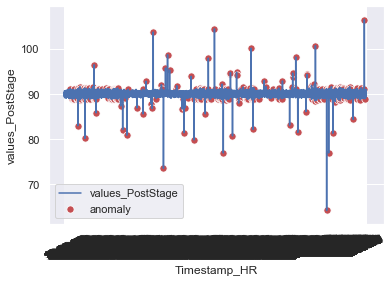

In [48]:
plt.plot(
  val.index, 
  val.values_PostStage, 
  label='values_PostStage'
);

sns.scatterplot(
  anomalies.index,
  anomalies.values_PostStage,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

## Save Model

In [49]:
# save all model information, including weights, in h5 format
model.save("sensor_model.h5")
print("Model saved")

Model saved
